# Premature Optimization is the root of all evil

In [1]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from numba import jit
import pstats
import heapq
import time
import cProfile
import pandas as pd

In [2]:
puzzle_info_path = 'puzzle_info.csv'
puzzles_path = 'puzzles.csv'
sample_submission_path = 'sample_submission.csv' # change name across board
puzzle_info_df = pd.read_csv(puzzle_info_path)
puzzles_df = pd.read_csv(puzzles_path)
sample_submission_df = pd.read_csv(sample_submission_path)

In [3]:
puzzles_df.head()

,id,puzzle_type,solution_state,initial_state,num_wildcards
0,0,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,D;E;D;A;E;B;A;B;C;A;C;A;D;C;D;F;F;F;E;E;B;F;B;C,0
1,1,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,D;E;C;B;B;E;F;A;F;D;B;F;F;E;B;D;A;A;C;D;C;E;A;C,0
2,2,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,E;F;C;C;F;A;D;D;B;B;A;F;E;B;C;A;A;B;D;F;E;E;C;D,0
3,3,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,A;C;E;C;F;D;E;D;A;A;F;A;B;D;B;F;E;D;B;F;B;C;C;E,0
4,4,cube_2/2/2,A;A;A;A;B;B;B;B;C;C;C;C;D;D;D;D;E;E;E;E;F;F;F;F,E;D;E;D;A;E;F;B;A;C;F;D;F;D;C;A;F;B;C;C;B;E;B;A,0


In [4]:
# Parsing the initial_state and solution_state columns
# Converting the semicolon-separated string values into lists of colors
puzzles_df['parsed_initial_state'] = puzzles_df['initial_state'].apply(lambda x: x.split(';'))
seen = {}

for i in range(len(puzzles_df['parsed_initial_state'])):
    for j in range(len(puzzles_df['parsed_initial_state'][i])):
        if puzzles_df['parsed_initial_state'][i][j] not in seen:
            seen[puzzles_df['parsed_initial_state'][i][j]] = len(seen)
        puzzles_df['parsed_initial_state'][i][j] = seen[puzzles_df['parsed_initial_state'][i][j]]

puzzles_df['parsed_solution_state'] = puzzles_df['solution_state'].apply(lambda x: x.split(';'))

for i in range(len(puzzles_df['parsed_solution_state'])):
    for j in range(len(puzzles_df['parsed_solution_state'][i])):
        puzzles_df['parsed_solution_state'][i][j] = seen[puzzles_df['parsed_solution_state'][i][j]]

# Displaying the modified dataframe with parsed states
puzzles_df[['id', 'puzzle_type', 'parsed_initial_state', 'parsed_solution_state']].head()

,id,puzzle_type,parsed_initial_state,parsed_solution_state
0,0,cube_2/2/2,"[0, 1, 0, 2, 1, 3, 2, 3, 4, 2, 4, 2, 0, 4, 0, ...","[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, ..."
1,1,cube_2/2/2,"[0, 1, 4, 3, 3, 1, 5, 2, 5, 0, 3, 5, 5, 1, 3, ...","[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, ..."
2,2,cube_2/2/2,"[1, 5, 4, 4, 5, 2, 0, 0, 3, 3, 2, 5, 1, 3, 4, ...","[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, ..."
3,3,cube_2/2/2,"[2, 4, 1, 4, 5, 0, 1, 0, 2, 2, 5, 2, 3, 0, 3, ...","[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, ..."
4,4,cube_2/2/2,"[1, 0, 1, 0, 2, 1, 5, 3, 2, 4, 5, 0, 5, 0, 4, ...","[2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 0, ..."


In [5]:
import json

# Converting the string representation of allowed_moves to dictionary
puzzle_info_df['allowed_moves'] = puzzle_info_df['allowed_moves'].apply(lambda x: json.loads(x.replace("'", '"')))

# Selecting an example puzzle type and displaying its allowed moves
example_puzzle_type = puzzle_info_df['puzzle_type'].iloc[0]
example_allowed_moves = puzzle_info_df[puzzle_info_df['puzzle_type'] == example_puzzle_type]['allowed_moves'].iloc[0]

example_puzzle_type

'cube_2/2/2'

In [6]:
def getInversePerm(arr):
    # gets the inverse move for a certain move
    res = [0 for i in range(len(arr))]
    for i in range(len(arr)):
        res[arr[i]] = i
    return res
    
# type : (np.array(move_perm_i), np.array(name_i))
puz_info = {}

# type : {move : perm}
move_to_perm = {}

for i in range(len(puzzle_info_df)):
    puz_info[puzzle_info_df['puzzle_type'][i]] = [[], []]
    move_to_perm[puzzle_info_df['puzzle_type'][i]] = {}
    
    for j in puzzle_info_df['allowed_moves'][i].keys():
        puz_info[puzzle_info_df['puzzle_type'][i]][1].append(j)
        puz_info[puzzle_info_df['puzzle_type'][i]][0].append(np.array(puzzle_info_df['allowed_moves'][i][j]))

        puz_info[puzzle_info_df['puzzle_type'][i]][1].append(str('-' + j)) # might be the opposite
        puz_info[puzzle_info_df['puzzle_type'][i]][0].append(np.array(getInversePerm(puzzle_info_df['allowed_moves'][i][j])))

        move_to_perm[puzzle_info_df['puzzle_type'][i]][str('-' + j)] = np.array(getInversePerm(puzzle_info_df['allowed_moves'][i][j]))
        move_to_perm[puzzle_info_df['puzzle_type'][i]][j] = np.array(puzzle_info_df['allowed_moves'][i][j])

# move_to_perm['cube_2/2/2']

In [7]:
# optimize reference solution
reference_solution = pd.read_csv(sample_submission_path)
reference_solution

,id,moves
0,0,r1.-f1
1,1,f1.d0.-r0.-f1.-d0.-f1.d0.-r0.f0.-f1.-r0.f1.-d1...
2,2,f1.d0.-d1.r0.-d1.-f0.f1.-r0.-f0.-r1.-f0.r0.-d0...
3,3,-f0.-r0.-f0.-d0.-f0.f1.r0.-d1.-r0.-r1.-r0.-f1....
4,4,d1.-f1.d1.r1.-f0.d1.-d0.-r1.d1.d1.-f1.d1.-d0.-...
...,...,...
393,393,f19.f21.-f39.f20.f2.-f5.f7.-r3.f55.-f12.f65.-f...
394,394,-f31.-f22.f16.-f17.-f13.-f24.-f14.f2.f21.f44.f...
395,395,-r0.-f42.-f8.f16.-f49.f14.-f1.f56.f26.f35.f62....
396,396,f25.-f29.f46.f49.-f8.f27.f26.-f20.f2.-f20.f6.f...


In [8]:
# import random
# from tqdm import tqdm

# class Node:
#     def __init__(self, state, parent=None, move=None):
#         self.state = state
#         self.parent = parent
#         self.move = move
#         self.children = []
#         self.wins = 0
#         self.visits = 0
#         self.untried_moves = get_possible_moves(state)

#     def select_child(self):
#         # UCB1 formula for child selection
#         return max(self.children, key=lambda c: c.wins / c.visits + math.sqrt(2 * math.log(self.visits) / c.visits))

#     def add_child(self, move, state):
#         # Add a new child node for this move
#         child_node = Node(state=state, parent=self, move=move)
#         self.untried_moves.remove(move)
#         self.children.append(child_node)
#         return child_node

#     def update(self, result):
#         # Update this node with the simulation result
#         self.visits += 1
#         self.wins += result

# def get_possible_moves(state):
#     # Assuming move_perm is a global variable defining permutations for moves
#     return list(range(len(move_perm)))

# def apply_move(state, move_index):
#     # Apply the permutation defined by move_perm[move_index] to state
#     return state[move_perm[move_index]]

# def is_terminal(state, goal_state, max_dist):
#     # Check if the state is within max_dist of the goal state
#     return np.sum(state != goal_state) <= max_dist

# def monte_carlo_tree_search(idx, number_of_simulations=1000):
#     global puzzles_df, puz_info, move_perm

#     initial_state = np.array(puzzles_df['parsed_initial_state'][idx])
#     goal_state = np.array(puzzles_df['parsed_solution_state'][idx])
#     max_dist = puzzles_df['num_wildcards'][idx]
#     move_perm = np.array(puz_info[puzzles_df['puzzle_type'][idx]][0])

#     root = Node(state=initial_state)

#     for _ in tqdm(range(number_of_simulations)):
#         node = root
#         state = initial_state.copy()

#         # Selection
#         while node.untried_moves == [] and node.children != []:
#             node = node.select_child()
#             state = apply_move(state, node.move)

#         # Expansion
#         if node.untried_moves != []:
#             move = random.choice(node.untried_moves)
#             state = apply_move(state, move)
#             node = node.add_child(move, state)

#         # Simulation
#         while not is_terminal(state, goal_state, max_dist):
#             move = random.choice(get_possible_moves(state))
#             state = apply_move(state, move)

#         # Backpropagation
#         simulation_result = 1 if is_terminal(state, goal_state, max_dist) else 0
#         while node is not None:
#             node.update(simulation_result)
#             node = node.parent

#     # Return the move that leads to the best node
#     best_move = sorted(root.children, key=lambda c: c.visits)[-1].move
#     return best_move

# # Example usage:
# idx = 0  # Puzzle index
# best_move = monte_carlo_tree_search(idx)

In [9]:
@jit(nopython=True, parallel = True, fastmath = True)
def hash_perm(perm):
    base = 9973
    modb = 1000000007
    modc = 1000000009

    B, C = 0, 0
    for i in perm:
        B = (B * base) % modb + i
        C = (C * base) % modc + i

    return (B, C)

def dist(a, b):
    return np.count_nonzero(a != b)

In [10]:
# 1e6 ~ 2 seconds
mx_mem = int(1e7)
mem_idx = 0

last_state = np.zeros(mx_mem, dtype=int)
last_move = np.zeros(mx_mem, dtype=int)

print(last_state)

[0 0 0 ... 0 0 0]


In [ ]:
%%time

test10 = []
test30 = []
test50 = []
test70 = []
pq = []
improvements = []

def a_star_search(idx):
    global mem_idx
    
    initial_state = np.array(puzzles_df['parsed_initial_state'][idx])
    goal_state = np.array(puzzles_df['parsed_solution_state'][idx])
    max_dist = puzzles_df['num_wildcards'][idx]
    move_perm = np.array(puz_info[puzzles_df['puzzle_type'][idx]][0])

    n = len(initial_state)
    m = len(move_perm)

    # Pruning 1: Over the entire tree, what is the average dist for path length? 
    # We make a branch dead if it's a lot worse than other branches of same length
    # -> don't consider branch in the first place

    # TODO: Implement a "momentum" modifier --> the more time a path "beats out" avg_dist in upd_prune, the more momentum it gathers, 
    # making it more likely to be picked next (so lower priority)

    avg_dist = np.array([n + 1 for i in range(500 * n)], dtype = np.float32)
    mx_dist = np.array([-1 for i in range(500 * n)]) # must ensure no outliers skew max/min -> follows guassian?
    n_dist = np.array([0 for i in range(500 * n)])

    #don't update avg every other time when its below
    def upd_prune(nxt_p, nxt_dist):
        if n_dist[nxt_p] == 0:
            # mx_dist[nxt_p], avg_dist[nxt_p] = nxt_dist, nxt_dist
            avg_dist[nxt_p] = nxt_dist
            n_dist[nxt_p] = 1
            return True

        if n_dist[nxt_p] > 500: #min samples needed to start pruning
            if nxt_dist > avg_dist[nxt_p]:
                return False
            # P = 1 - (nxt_dist - avg_dist[nxt_p]) / (mx_dist[nxt_p] - avg_dist[nxt_p]) * 100
            # if np.random.rand() > P:
            #     return False

        if nxt_p == 10:
            test10.append((nxt_dist, mem_idx))
        if nxt_p == 50:
            test50.append((nxt_dist, mem_idx))
        if nxt_p == 30:
            test30.append((nxt_dist, mem_idx))
        if nxt_p == 70:
            test70.append((nxt_dist, mem_idx))
        
        # mx_dist[nxt_p] = max(mx_dist[nxt_p], nxt_dist)
        avg_dist[nxt_p] *= n_dist[nxt_p] / (n_dist[nxt_p] + 1)
        avg_dist[nxt_p] += nxt_dist / (n_dist[nxt_p] + 1)
        n_dist[nxt_p] += 1
        return True
    
    # Pruning 2: as tree grows larger, we want to be more selective about the paths we chose --> exponential fall-off
    # We don't want to be stuck explore paths of length 2 - 3 if our deepest path is already 10+
    # Even if there is a better path of length 2 - 3, it's unlikely to ever be explored anyways at that point
    # Temporary solution: above 30% of max_length -> automatically ok, otherwise, linearly decrease chosen probability
    # Depends a lot on the type of puzzles (# of branches per node)

    mx_len = 0
    
    # Let's make 1 & 2 have a multiplicative effect

    # Edge-reduce 3: artificially reduce the number of edges per node
    # Some valid out going edges are worse than others.
    # Get rid of the ones that are significantly worse
    
    # pq = []
    heapq.heappush(pq, (0, mem_idx, initial_state, 0))  # (priority, mem_idx, state, path_length)
    mem_idx += 1

    pruned_branch = 0
    
    best_so_far = 1e18
    S = time.time()
    considered = set()
    considered.add(hash_perm(initial_state))
    while mem_idx + m < mx_mem:
        cur_p_plus_dist, cur_idx, cur_state, cur_p = heapq.heappop(pq) 
        cur_dist = cur_p_plus_dist - cur_p

        # experimentation taught me to not put stuff here... everything in heap is already a carefully selected "ok" branch
        # if mx_len > 50 and np.random.rand() > 1 + cur_p / mx_len - 0.3: # Pruning 2 (too risky) --> missing results in HUGE penalty
        #     pruned_branch += 1
        #     continue

        mx_len = max(mx_len, cur_p + 1)

        # all_outs = []
        
        for i in range(m):
            nxt_state = cur_state[move_perm[i]]
            nxt_hash = hash_perm(nxt_state)
            nxt_p = 1 + cur_p

            nxt_dist = dist(nxt_state, goal_state)
            
            # Pruning 1 Start
            ok = upd_prune(nxt_p, nxt_dist)
            if not ok:
                pruned_branch += 1
                continue
            # Pruning 1 End

            # if mx_len > 20 and np.random.rand() > 1 + nxt_p / mx_len - 0.3: # Pruning 2 (too risky) --> missing results in HUGE penalty
            #     pruned_branch += 1
            #     continue

            if nxt_hash in considered:
                continue
            considered.add(nxt_hash)

            if nxt_dist < best_so_far:
                improvements.append((time.time() - S, nxt_dist))
                print(nxt_dist)
                best_so_far = nxt_dist

        # edge reduce 3 Start: <-- Doesn't work atm, makes thigns slower only
            
        #     all_outs.append((nxt_dist, nxt_hash, nxt_state))

        # all_outs = list(sorted(all_outs))
        # print(all_outs)
        
        # for i in range(int(0.9 * len(all_outs))):
        #     nxt_dist, nxt_hash, nxt_state = all_outs[i]
        #     nxt_p = 1 + cur_p

        # edge reduce 3 End:
            
            last_state[mem_idx] = cur_idx
            last_move[mem_idx] = i

            if nxt_dist <= max_dist:
                print("Number of pruned branches", pruned_branch)
                print("Final length", cur_p)
                print("Final Dist", nxt_dist)
                
                return mem_idx
            
            priority = nxt_p + nxt_dist
            heapq.heappush(pq, (priority, mem_idx, nxt_state, 1+cur_p))
            mem_idx += 1
    return None

mem_idx = 0
# cProfile.run('a_star_search(30)')
# print(puzzles_df['puzzle_type'][3])
print(a_star_search(30))

# cProfile.run('a_star_search(29)')

# 4.1, 6.57
# 4.01, 6.smth, 

42
38
36
35
33
32
29
28
27
26
25
24
23
22
21
20
19
16
15
13
12
11
10
8
6


4571


(array([ 188.,  173.,  318.,  368.,  412., 1070.,  736.,  600.,  561.,
         145.]),
 array([1383. , 1384.2, 1385.4, 1386.6, 1387.8, 1389. , 1390.2, 1391.4,
        1392.6, 1393.8, 1395. ]),
 <BarContainer object of 10 artists>)

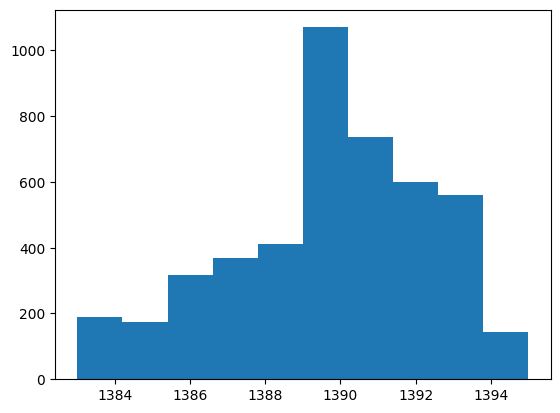

In [231]:
print(len(pq))

fringe_lengths = [] # all path lengths on fringe
for j in pq:
    fringe_lengths.append(j[3])

plt.hist(fringe_lengths)

For path length 10, distribution of distances
12842


(array([  15.,   96.,  827., 3563., 6138., 1653.,  298.,  135.,   89.,
          28.]),
 array([20. , 21.9, 23.8, 25.7, 27.6, 29.5, 31.4, 33.3, 35.2, 37.1, 39. ]),
 <BarContainer object of 10 artists>)

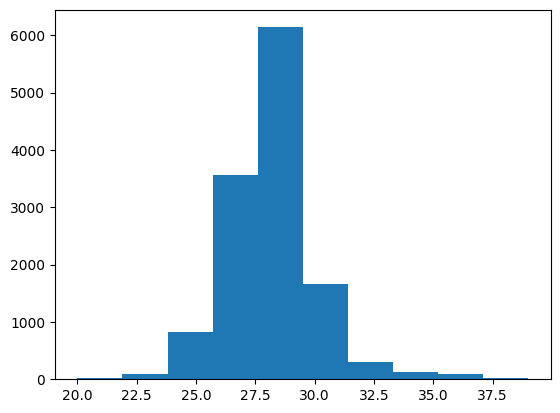

In [232]:
print("For path length 10, distribution of distances")
print(len(test10))
temp = []
for i in test10:
    temp.append(i[0])
plt.hist(temp)

For path length 10, distribution of times (where we changed the average)
12842


(array([1513.,  648., 1079., 1144., 1752., 1681., 1613., 1157.,  769.,
        1486.]),
 array([   296. ,  10795.4,  21294.8,  31794.2,  42293.6,  52793. ,
         63292.4,  73791.8,  84291.2,  94790.6, 105290. ]),
 <BarContainer object of 10 artists>)

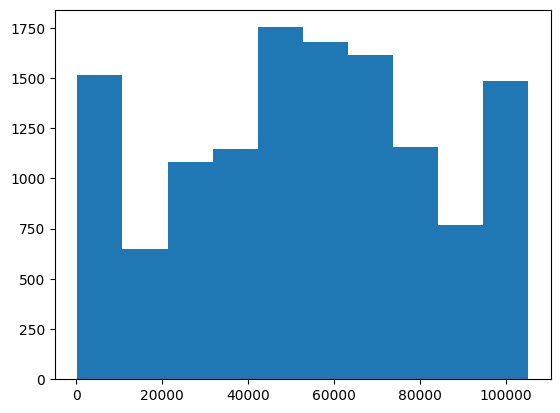

In [233]:
print("For path length 10, distribution of times (where we changed the average)")
print(len(test10))
temp = []
for i in test10:
    temp.append(i[1])
plt.hist(temp)

2683


(array([125., 489., 454., 403.,  78., 487., 279., 221.,  62.,  85.]),
 array([ 89644. ,  92267.4,  94890.8,  97514.2, 100137.6, 102761. ,
        105384.4, 108007.8, 110631.2, 113254.6, 115878. ]),
 <BarContainer object of 10 artists>)

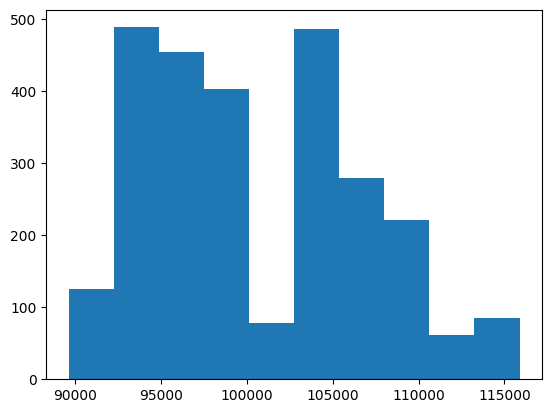

In [234]:
print(len(test30))
temp = []
for i in test30:
    temp.append(i[1])
plt.hist(temp)

In [235]:
print(len(test50))

2591


2591


(array([197., 685., 614., 564.,  94.,  74., 150.,  87.,  77.,  49.]),
 array([123612. , 125266.4, 126920.8, 128575.2, 130229.6, 131884. ,
        133538.4, 135192.8, 136847.2, 138501.6, 140156. ]),
 <BarContainer object of 10 artists>)

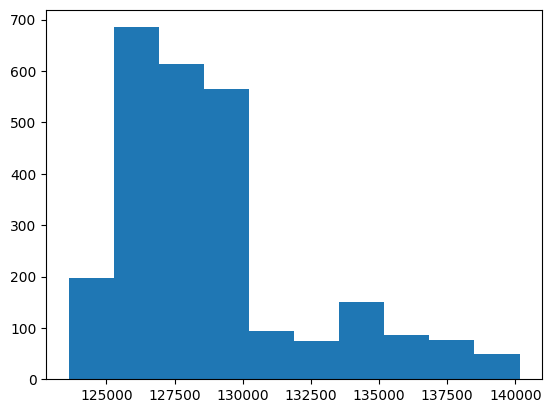

In [236]:
print(len(test50))
temp = []
for i in test50:
    temp.append(i[1])
plt.hist(temp)

In [237]:
print(len(test70))

2930


2930


(array([535., 738., 662., 366., 136., 163.,  69.,  99.,  93.,  69.]),
 array([148928. , 150671.1, 152414.2, 154157.3, 155900.4, 157643.5,
        159386.6, 161129.7, 162872.8, 164615.9, 166359. ]),
 <BarContainer object of 10 artists>)

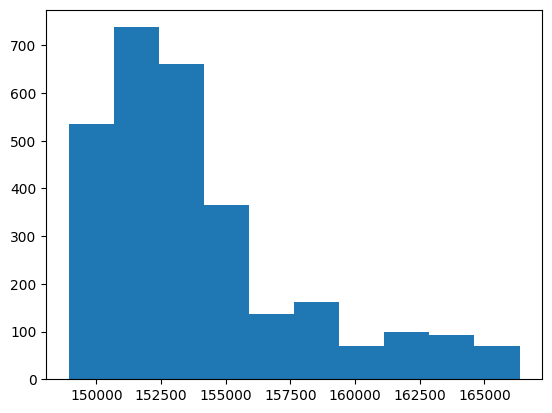

In [238]:
print(len(test70))
temp = []
for i in test70:
    temp.append(i[1])
plt.hist(temp)

In [240]:
print(len(improvements))

1


In [166]:
%%time
def dig_through_memory(idx):
    res = []
    while idx != 0:
        res.append(last_move[idx])
        idx = last_state[idx]

    res = list(reversed(res))
    return res

def solve(idx):
    global mem_idx
    
    mem_idx = 0
    
    move_name = np.array(puz_info[puzzles_df['puzzle_type'][idx]][1])

    res = a_star_search(idx)
    
    if res == None:
        return None

    res = dig_through_memory(res)
    for i in range(len(res)):
        res[i] = move_name[res[i]]

    return res

A = solve(30)
A

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

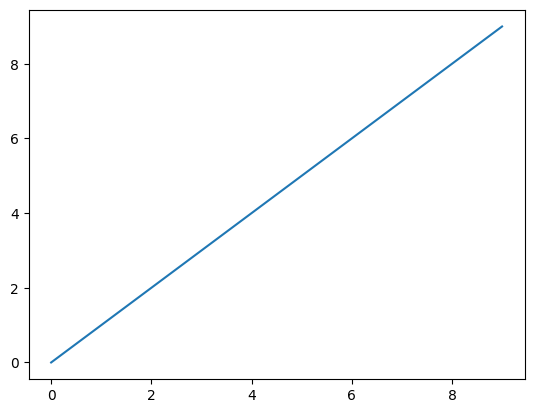

In [15]:

ys = [i for i in range(10)]
plt.plot(xs, ys)

# Step 6: Build submission format function

In [28]:
def format_solution_for_submission(puzzle_id, solution_moves):
    """
    Format the solution to a puzzle for submission.

    :param puzzle_id: The unique identifier of the puzzle.
    :param solution_moves: List of tuples representing the solution moves.
    :return: Formatted string suitable for submission.
    """
    formatted_moves = []
    for move in solution_moves:
        formatted_moves.append(move)

    # Joining the moves into a single string separated by periods
    return {'id': puzzle_id, 'moves': '.'.join(formatted_moves)}


# Step 7: Define solve function

In [29]:
from tqdm import tqdm

all_ok = []
res_df = []

for i in tqdm(range(len(puzzles_df))):
    res = solve(i)
    # print(res)
    if res == None:
        res = format_solution_for_submission(i, sample_submission_df['moves'][i].split('.'))
    else:
        all_ok.append(i)
        res = format_solution_for_submission(i, res)
    res_df.append(res)

  0%|                                                   | 0/398 [00:00<?, ?it/s]

OK : 0 16
num [6, 3]
OK : 1 13131
num [0, 6, 2, 9, 9, 2, 9, 3, 8]


  1%|▎                                          | 3/398 [00:01<03:15,  2.02it/s]

OK : 2 776542
num [3, 5, 1, 7, 1, 8, 7, 9, 0, 8, 8, 1]


  1%|▎                                          | 3/398 [00:02<05:00,  1.31it/s]


KeyboardInterrupt: 

In [ ]:
for i in tqdm(range(len(res_df), len(puzzles_df))):
    res = None
    # print(res)
    if res == None:
        res = format_solution_for_submission(i, sample_submission_df['moves'][i].split('.'))
    else:
        all_ok.append(i)
        res = format_solution_for_submission(i, res)
    res_df.append(res)

In [ ]:
print(all_ok)

In [ ]:
res_df = pd.DataFrame(res_df)
res_df

# Step 9: Save submission

In [ ]:
# Define the file path for the output CSV file
output_csv_path = 'submission.csv'

# Save the output DataFrame to a CSV file
res_df.to_csv(output_csv_path, index=False)

# Return the path of the saved file
output_csv_path